# Extracting a 1D profile (adapted from Song's *illustris_test.ipynb*)

## setup:


### Python 2
I recommend using [anaconda](https://docs.anaconda.com/anaconda/install/) and setting up a [python environment](https://conda.io/docs/user-guide/tasks/manage-environments.html) for this project.

* For example, you could type this in your terminal to create the "illustris_profiles" environment:
    
    **conda create -n illustris_profiles python=2.7 iraf-all pyraf-all stsci numpy astropy matplotlib**

   

### sep
*After* activating your environment (**source activate illustris_profiles**), you can install sep by typing:

**pip install sep**

### h5py
similarly for h5py:

**pip install h5py**

### kungpao
This is a bit more complicated. It is Song's code which does all of the profile fitting. 

* You will need to clone his [GitHub repo](https://github.com/dr-guangtou/kungpao) and then note the location of the directory on your computer in the import below.

* Also note the location of the following iraf files:
    * *x_images.e*
    * *x_ttools.e*
    * *x_isophote.e*
    
    It might look something like this: */Users/fardila/anaconda/envs/hsc_hydro/iraf_extern/tables/bin.macosx/x_ttools.e*
    
    You will need to add the paths below.

## Imports

In [1]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

from __future__ import print_function, \
    division, \
    absolute_import

import os

import sep
import h5py

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

from astropy.io import fits
from astropy.modeling import models, fitting

#---------------------------------------------------------------------------#
#User imports
import sys
####################################################################################
sys.path.append('/Users/fardila/Documents/Github/kungpao') 
#REPLACE '/Users/fardila/Documents/Github/kungpao' WITH THE ACTUAL PATH TO THE KUNGPAO DIRECTORY

from kungpao.galsbp import galSBP
from kungpao.display import display_single, random_cmap

Created TAP+ (v1.0) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


## Add the paths to the iraf files here:

In [2]:
# For Kungpao
x_images = '/Users/fardila/anaconda/envs/hsc_hydro/iraf/bin.macosx/x_images.e'
x_ttools = '/Users/fardila/anaconda/envs/hsc_hydro/iraf_extern/tables/bin.macosx/x_ttools.e'
x_isophote = '/Users/fardila/anaconda/envs/hsc_hydro/iraf_extern/stsdas/bin.macosx/x_isophote.e'
#---------------------------------------------------------------------------#

#---------------------------------------------------------------------------#
# About the Colormaps
IMG_CMAP = plt.get_cmap('viridis')
IMG_CMAP.set_bad(color='black')

SEG_CMAP = random_cmap(ncolors=512, background_color=u'white')
SEG_CMAP.set_bad(color='white')
SEG_CMAP.set_under(color='white')

In [3]:
from pyraf import iraf

iraf.tables()
iraf.stsdas()
iraf.analysis()
iraf.isophote()

iraf.unlearn('ellipse')
iraf.unlearn('bmodel')



      +------------------------------------------------------------+
      |             Space Telescope Tables Package                 |    
      |                  TABLES Version 3.17                       |
      |                                                            |
      |   Space Telescope Science Institute, Baltimore, Maryland   |
      |   Copyright (C) 2014 Association of Universities for       |
      |            Research in Astronomy, Inc.(AURA)               |
      |       See stsdas$copyright.stsdas for terms of use.        |
      |         For help, send e-mail to help@stsci.edu            |
      +------------------------------------------------------------+
tables/:
 fitsio/        tbplot/         tobsolete/      ttools/


      +------------------------------------------------------------+
      |       Space Telescope Science Data Analysis System         |    
      |                   STSDAS Version 3.17                      |
      |                   

# If everything has worked so far then we can get started with the science!

In [4]:
def load_pkl(filename):
    try:
        import cPickle as pickle
    except:
        warnings.warn("## cPickle is not available!!")
        import pickle
    
    if os.path.isfile(filename):
        pklFile = open(filename, 'rb')
        data = pickle.load(pklFile)    
        pklFile.close()
    
        return data
    else: 
        warnings.warn("## Can not find %s, return None" % filename)
        return None
    
    
def save_to_fits(image, name):
    """
    Save a 2-D array as fits image.
    """
    hdu = fits.PrimaryHDU(image)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(name, overwrite=True)
    
    return


def show_illustris(img_cen, img_sat, img_icl, img_all):
    """
    Show the images of Illustris simulated galaxy.
    """
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                        top=1.0, right=1.0, 
                        left=0.0, bottom=0.0)

    ax1 = plt.subplot(2, 2, 1)
    ax1 = display_single(img_all, ax=ax1, 
                         contrast=0.15,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)

    ax2 = plt.subplot(2, 2, 2)
    ax2 = display_single(img_cen, ax=ax2, 
                         contrast=0.10,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)

    ax3 = plt.subplot(2, 2, 3)
    ax3 = display_single(img_sat, ax=ax3, 
                         contrast=0.12,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)

    ax4 = plt.subplot(2, 2, 4)
    ax4 = display_single(img_icl, ax=ax4, 
                         contrast=0.01,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)
    
    return fig

# Understanding the HDF files

Illustris files are available from Benedikt's site [here](https://www.cfa.harvard.edu/~bdiemer/illustris/).

The README file (on slack) is very helpful in understanding what each of the keywords mean.

In [61]:
illustris_file = 'galaxies_orig_large.hdf5'

# Load file
f = h5py.File(illustris_file, 'r')

#HDF files have attributes: metadata attached to the whole dataset
print('Attribute keys : ', f.attrs.keys())

#they can be called with their keywords. For example the redshift of this data snapshot is called with 'snap_z'
print('Redshift :', f.attrs['snap_z'])

Attribute keys :  [u'sim', u'snap_idx', u'snap_a', u'snap_z', u'stellar_map_size', u'stellar_map_np']
Redshift : 0.39993


In [62]:
#Then there is the actual data, which is also called with keywords 
print('Dataset keys : ', f.keys())

#For each dataset we can look at its shape
for key in f.keys():
    print(key, f[key].shape)
    

print(('There are %d galaxies')%(len(f[key])))
f.close()

Dataset keys :  [u'cat_grp_id', u'cat_grp_is_primary', u'cat_grp_m200c', u'cat_grp_n', u'cat_sh_bh_mdot', u'cat_sh_halfmrad_gas', u'cat_sh_halfmrad_stars', u'cat_sh_id', u'cat_sh_mbh', u'cat_sh_mdm', u'cat_sh_mdm_2rhalf', u'cat_sh_mdm_rhalf', u'cat_sh_metallicity', u'cat_sh_mgas', u'cat_sh_mgas_2rhalf', u'cat_sh_mgas_rhalf', u'cat_sh_mstar', u'cat_sh_mstar_2rhalf', u'cat_sh_mstar_rhalf', u'cat_sh_phot_B', u'cat_sh_phot_K', u'cat_sh_phot_U', u'cat_sh_phot_V', u'cat_sh_phot_g', u'cat_sh_phot_i', u'cat_sh_phot_r', u'cat_sh_phot_z', u'cat_sh_pos_bound', u'cat_sh_pos_cm', u'cat_sh_sfr', u'cat_sh_spin', u'cat_sh_vel', u'cat_sh_vmax', u'map_stars_exsitu', u'map_stars_exsitu_nptl', u'map_stars_insitu', u'map_stars_insitu_nptl']
cat_grp_id (5,)
cat_grp_is_primary (5,)
cat_grp_m200c (5,)
cat_grp_n (5,)
cat_sh_bh_mdot (5,)
cat_sh_halfmrad_gas (5,)
cat_sh_halfmrad_stars (5,)
cat_sh_id (5,)
cat_sh_mbh (5,)
cat_sh_mdm (5,)
cat_sh_mdm_2rhalf (5,)
cat_sh_mdm_rhalf (5,)
cat_sh_metallicity (5,)
cat_sh_m

## We can see that all of the datasets have a length of 5 along the zeroth axis, which means there are 5 galaxies in this file

## Now let's look at some stellar maps

In [89]:
illustris_file = 'galaxies_orig_large.hdf5'

# Load file
f = h5py.File(illustris_file, 'r')

#we want the 'map_stars' keyword. but here it is separated by insitu and exsitu
map_stars_insitu = np.array(f['map_stars_insitu'])
map_stars_exsitu = np.array(f['map_stars_exsitu'])

#the shape tells us about the number of galaxies, components, projections, and pixels
#5 galaxies
#3 components : central (0), satellites (1), unbound (2)
#3 projections : xy (0), xz (1), yz(2)
# 200 by 200 pixels
print(map_stars_insitu.shape)


#determine pixel scale
map_size = f.attrs['stellar_map_size'] #kpc on half of one side
n_pixels = f.attrs['stellar_map_np'] #pixels on half of one side
pixel_scale = 2 * (map_size/n_pixels) #kpc / pixel 
print('%f kpc, %d pixels, %f kpc/pixel' % (map_size, n_pixels, pixel_scale))

(5, 3, 3, 200, 200)
1500.000000 kpc, 200 pixels, 15.000000 kpc/pixel


# Use Galaxy 0, Projection 1 as example

In [90]:
img_insitu = map_stars_insitu[0, 0, 1] * (pixel_scale ** 2) # [galaxy (0), central (0), projection(1)]
img_exsitu = map_stars_exsitu[0, 0, 1] * (pixel_scale ** 2) # [galaxy (0), central (0), projection(1)]
img_both = img_insitu + img_exsitu



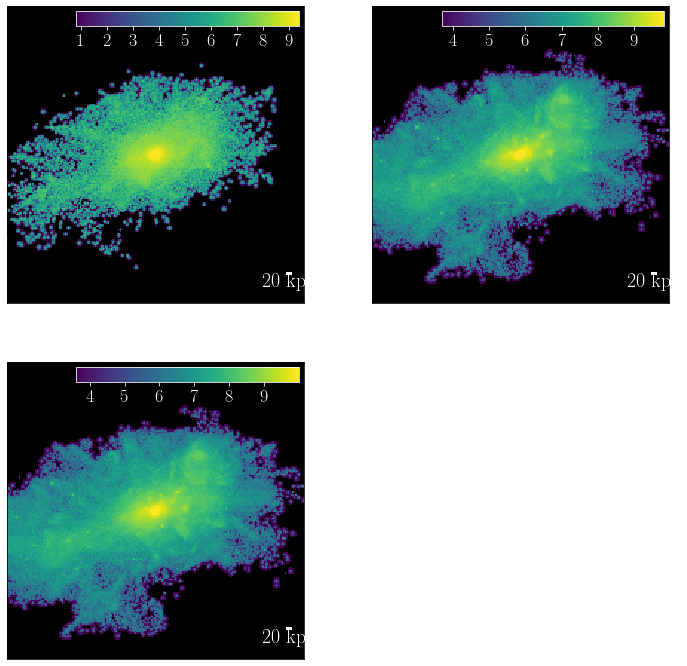

In [93]:
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
display_single(img_insitu, ax=ax1, contrast=0.50,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=pixel_scale,
                         color_bar=True)
display_single(img_exsitu, ax=ax2, contrast=0.50,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=pixel_scale,
                         color_bar=True)
display_single(img_both, ax=ax3, contrast=0.50,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=pixel_scale,
                         color_bar=True)

## Measure the profiles on both components, central-only image

In [103]:
img_cen = img_both

#save as a fits file for measurements
fits_prefix = 'illustris_1_xy'
save_to_fits(img_cen, fits_prefix + '_cen.fits')

### Step 0: Measure background and find object center

In [97]:
# First, do a simple detection and find the center of the central galaxy 

# Measure the background,
# Here on the image has no noise and has a lot of diffuse features
# so measure sky using a very small box (bw, bh values) helps us remove 
# a lot of the them, make the detection easier
# See: http://sep.readthedocs.io/en/v1.0.x/api/sep.Background.html#sep.Background 
# For more details
bkg_cen = sep.Background(img_cen, 
                         bw=10, bh=10, 
                         fw=5, fh=5)
print("# Mean Sky / RMS Sky = %10.5f / %10.5f" % (bkg_cen.globalback, bkg_cen.globalrms))

# Object detection after subtracting the background
# Since there is no noise on the image, we will just use the global RMS 
# from the background estimate as error
# Here, we use very high threshold, less aggressive deblending method to 
# make the detection focuses on the big object
objs_cen, seg_cen = sep.extract(img_cen - bkg_cen.back(), 
                                20.0,
                                err=bkg_cen.globalrms,
                                minarea=1000,
                                deblend_nthresh=24, 
                                deblend_cont=0.1,
                                segmentation_map=True)

print(objs_cen['x'], objs_cen['y'])

# Mean Sky / RMS Sky =  414.88403 / 4558.17676
[ 99.20835644] [ 99.82988689]


### Stage 1: leave the center and the shape (ellipticity and PA) of the isophote free

In [112]:
# This is how we run surface brightness profile extraction 

# This process will generate some output files
# The outputs are:  [An Astropy table for the isophotes table] [Name of the output binary file]

# galSBP can fit the profiles in 4 ways:
# stage = 1 : leave the center and the shape (ellipticity and PA) of the isophote free
# stage = 2 : fix the center, leave only the shape (ellipticity and PA) of the isophote free
# stage = 3 : fix the geometry of the isophote, extract the profile
# stage = 4 : extract the profile using a pre-defined profile (using a out)

# For now, you need the following parameters:
# galX, galY: central coordinate (initial values or fixed at these values)
# galQ, galPA: axis ratio, position angle (degree) (initial values or fixed at these values)
# iniSma [pix]: stars the fitting at this radius 
# maxSma [pix]: maximum radius for profile extraction
# ellipStep: step size for the profile, smaller value means finer profile


# Free center and geometry
iso_cen_1, iso_cen_1_bin = galSBP.galSBP('illustris_1_xy_cen.fits', 
                                         galX=objs_cen[0]['x'], 
                                         galY=objs_cen[0]['y'], 
                                         galQ=(objs_cen[0]['b'] / objs_cen[0]['a']), 
                                         galPA=(objs_cen[0]['theta'] * 180.0 / np.pi), 
                                         maxSma=150, 
                                         iniSma=10.0, 
                                         stage=1, 
                                         intMode='median', 
                                         ellipStep=0.1,
                                         pix=pixel_scale, 
                                         zpPhoto=0.0,
                                         isophote=x_isophote, 
                                         xttools=x_ttools,
                                         savePng=False, verbose=True)

print('# Output file : %s' % iso_cen_1_bin)
print('# Total stellar mass from the profile: logM = %7.4f' % (iso_cen_1['mag_tot'][0] / -2.5))

----------------------------------------------------------------------------------------------------
###      galX, galY :  99.2083564374 99.8298868949
###      galR :  20.0
###      iniSma, maxSma :  10.0 150
###      Stage :  1
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : illustris_1_xy_cen.fits
###      Input Image   : temp_UY3T1.fits
###      Output Binary : illustris_1_xy_cen_ellip_1.bin
----------------------------------------------------------------------------------------------------
------------

In [100]:
# The output is a Astropy table
# The useful information is: 
# sma [pix] : radius along the major axis 
# intens / int_err : intensitiy and its error, here is in unit of stellar mass per pixel
# x0 / y0 / x0_err / y0_err : central coordinates and errors 
# ell / ell_err : ellipticity of the isophote 
# pa / pa_err : position angle of the isophote 
# avg_x0 / avg_y0 / avg_q / avg_pa : intensity-weighted mean central coordinate, axis ratio
#                                    and position angle in the inner region of the profile
# growth_ori : curve-of-growth value, the total stellar mass within this isophote via integration.

iso_cen_1

sma,intens,int_err,pix_var,rms,ell,ell_err,pa,pa_err,x0,x0_err,y0,y0_err,grad,grad_err,grad_r_err,rsma,mag,mag_lerr,mag_uerr,tflux_e,tflux_c,tmag_e,tmag_c,npix_e,npix_c,a3,a3_err,b3,b3_err,a4,a4_err,b4,b4_err,ndata,nflag,niter,stop,a_big,sarea,a1,a1_err,b1,b1_err,a2,a2_err,b2,b2_err,pa_norm,sbp_ori,sbp_sub,sbp,intens_sub,intens_bkg,sbp_err,sbp_low,sbp_upp,sma_asec,rsma_asec,growth_ori,growth_sub,avg_x0,avg_y0,avg_q,avg_pa,avg_bkg,intens_cor,sbp_cor,growth_cor,rad_outer,mag_tot,mag_tot_ori,mag_tot_sub
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,133608800000.0,nan,nan,nan,nan,nan,nan,nan,100.7106,nan,100.6007,nan,-17498220000.0,nan,nan,0.0,-27.81459,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-25.428981385,-25.428981385,-25.428981385,133608800000.0,0.0,nan,nan,nan,0.0,0.0,0.0,0.0,100.549389185,100.527382469,0.752931173691,-68.0237354675,2126757.0,133606673243.0,-25.4289641023,0.0,72.6627824086,-30.7141867716,-30.7261092152,-30.7261092152
0.5209865,124492500000.0,579834304.0,2956586000.0,2090622000.0,0.3257177,0.06730725,-17.68783,7.313511,100.7106,0.01898247,100.6007,0.02539824,-38035760000.0,20151570000.0,0.5298058,0.8495846,-27.73786,0.005068915,0.00504504,133608800000.0,133608800000.0,-27.81459,-27.81459,1.0,1.0,-0.04557966,0.04997085,0.01206529,0.04253705,-0.08113153,0.05556189,-0.02102719,0.03538311,13,0,200.0,2.0,102551.7,2.0,-8406289.0,691999296.0,-50089668.0,668918784.0,-18390578.0,692477888.0,-51765324.0,668159616.0,-17.68783,-25.3522516972,-25.3522516972,-25.3522516972,124492500000.0,0.0,0.00504516777101,-25.357296865,-25.3472065294,1.5629595,1.11811617755,0.0,0.0,100.549389185,100.527382469,0.752931173691,-68.0237354675,2126757.0,124490373243.0,-25.352233149,0.0,72.6627824086,-30.7141867716,-30.7261092152,-30.7261092152
0.5730851,124256400000.0,678663872.0,3460520000.0,2446957000.0,0.3579736,0.0635744,-19.52667,6.408926,100.689,0.0201175,100.5635,0.02749442,-40799110000.0,19889890000.0,0.4875079,0.8700712,-27.7358,0.005946925,0.005913382,133608800000.0,133608800000.0,-27.81459,-27.81459,1.0,1.0,-0.02863069,0.04675025,0.01691988,0.04367572,-0.07676007,0.05310697,-0.004696852,0.03601871,13,0,200.0,2.0,104131.8,2.0,-4632606.0,873766592.0,-82551400.0,844623552.0,-10997969.0,874236800.0,-82631440.0,843535616.0,-19.52667,-25.3501906437,-25.3501906437,-25.3501906437,124256400000.0,0.0,0.00591394060656,-25.3561045843,-25.3442767031,1.7192553,1.14507805843,10867755357.3,10867755357.3,100.549389185,100.527382469,0.752931173691,-68.0237354675,2126757.0,124254273243.0,-25.3501720602,10867569346.1,72.6627824086,-30.7141867716,-30.7261092152,-30.7261092152
0.6303936,123350100000.0,638780608.0,3257155000.0,2303156000.0,0.3065818,0.06134655,-36.12907,7.001863,100.6036,0.02304596,100.5378,0.02543384,-39076650000.0,20246300000.0,0.5181176,0.8910518,-27.72785,0.005638042,0.005607218,133608800000.0,133608800000.0,-27.81459,-27.81459,1.0,1.0,0.01477977,0.04003849,0.03294897,0.04145531,-0.06161474,0.04056372,0.06827759,0.04267705,13,0,200.0,2.0,245644.4,2.0,17037404.0,607872512.0,-206829888.0,587597888.0,32467172.0,604896512.0,-198715856.0,583653952.0,-36.12907,-25.3422424912,-25.3422424912,-25.3422424912,123350100000.0,0.0,0.00560808307097,-25.3478505742,-25.3366344081,1.8911808,1.17269011006,35941257129.0,35941257129.0,100.549389185,100.527382469,0.752931173691,-68.0237354675,2126757.0,123347973243.0,-25.3422237711,35940638809.7,72.6

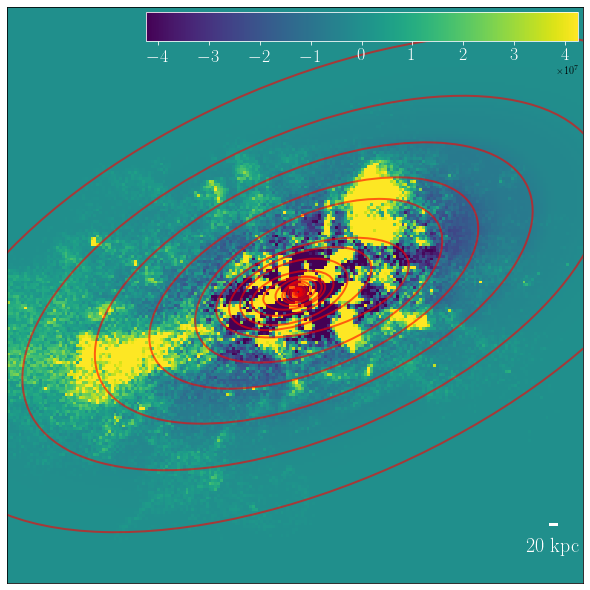

In [113]:
# Here, we use the stsdas.isophote.analysis.bmodel function to reconstruct 
# a 2-D model using the isophote information 
# So that we can subtract it from the original image, and see how well it does.

try: 
    os.remove(fits_prefix + '_cen_ellip_1.fits')
except Exception: 
    pass

iraf.bmodel(parent=fits_prefix + '_cen.fits', 
            table=iso_cen_1_bin,
            output=fits_prefix + '_cen_ellip_1.fits',
            minsma=0.0,
            highar='no')

img_cen_ellip_1 = fits.open(fits_prefix + '_cen_ellip_1.fits')[0].data

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.0, bottom=0.0,
                    top=1.0, right=1.0)
ax1 = fig.add_subplot(1, 1, 1)

ax1 = display_single(img_cen - img_cen_ellip_1, 
                     ax=ax1,
                     contrast=0.15,
                     scale_bar_length=20.0,
                     scale_bar_loc='right',
                     stretch='linear',
                     pixel_scale=1.0,
                     physical_scale=pixel_scale,
                     color_bar=True)

# Overplot a subsample of isophotes on the image
iso_cen_1_ellip = galSBP.convIso2Ell(iso_cen_1)
for ii, e in enumerate(iso_cen_1_ellip):
    if (ii % 3 == 0):
        ax1.add_artist(e)
        e.set_clip_box(ax1.bbox)
        e.set_alpha(0.6)
        e.set_edgecolor('r')
        e.set_facecolor('none')
        e.set_linewidth(2.0)

# Here, we can see the model becomes off-center quickly, and it reveals many 
# diffuse features underneath. 

Text(0.5,0,u'$\\mathrm{SMA}$')

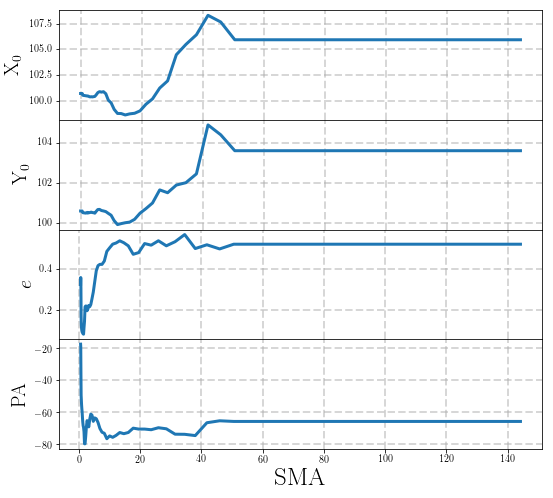

In [106]:
# Normally it is better to also check the profiles for geometry 

# Here you can see the central location changes with radius dramatically, 
# that tells you the image is asymmetric....which unfortunately makes the 
# profile extraction harder. 

fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(4, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax1.plot(iso_cen_1['sma'], iso_cen_1['x0'], linewidth=3.0)
ax1.set_ylabel(r'$\mathrm{X}_0$', fontsize=20)

ax2 = plt.subplot(4, 1, 2)
ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax2.plot(iso_cen_1['sma'], iso_cen_1['y0'], linewidth=3.0)
ax2.set_ylabel(r'$\mathrm{Y}_0$', fontsize=20)

ax3 = plt.subplot(4, 1, 3)
ax3.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax3.plot(iso_cen_1['sma'], iso_cen_1['ell'], linewidth=3.0)
ax3.set_ylabel(r'$e$', fontsize=20)

ax4 = plt.subplot(4, 1, 4)
ax4.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax4.plot(iso_cen_1['sma'], iso_cen_1['pa'], linewidth=3.0)
ax4.set_ylabel(r'$\mathrm{PA}$', fontsize=20)
ax4.set_xlabel(r'$\mathrm{SMA}$', fontsize=25)

### Stage 2: fix the center, and let the geometry to be free

In [114]:
# Now, let's fixe the center, and let the geometry to be free

iso_cen_2, iso_cen_2_bin = galSBP.galSBP('illustris_1_xy_cen.fits', 
                                         galX=100.0, 
                                         galY=100.0, 
                                         galQ=0.6, 
                                         galPA=-50.0, 
                                         maxSma=220, 
                                         iniSma=10.0, 
                                         stage=2, 
                                         intMode='median', 
                                         ellipStep=0.05,
                                         pix=pixel_scale, 
                                         zpPhoto=0.0,
                                         harmonics='1 2 3 4',
                                         isophote=x_isophote, 
                                         xttools=x_ttools,
                                         recenter=False,
                                         savePng=False, 
                                         verbose=True)

print('# Output file : %s' % iso_cen_2_bin)
print('# Total stellar mass from the profile: logM = %7.4f' % (iso_cen_2['mag_tot'][0] / -2.5))

----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  10.0 220
###      Stage :  2
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : illustris_1_xy_cen.fits
###      Input Image   : temp_GTES9.fits
###      Output Binary : illustris_1_xy_cen_ellip_2.bin
----------------------------------------------------------------------------------------------------
---------------------------

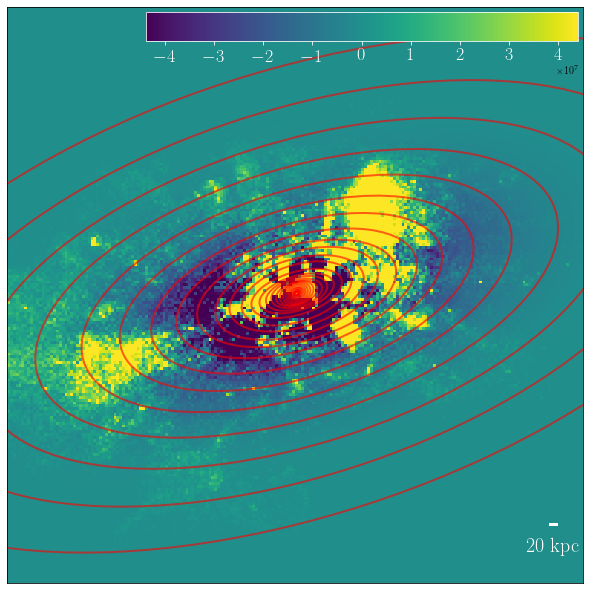

In [115]:
try: 
    os.remove(fits_prefix + '_cen_ellip_2.fits')
except Exception: 
    pass

iraf.bmodel(parent=fits_prefix + '_cen.fits', 
            table=iso_cen_2_bin,
            output=fits_prefix + '_cen_ellip_2.fits',
            minsma=0.0,
            highar='no')

img_cen_ellip_2 = fits.open(fits_prefix + '_cen_ellip_2.fits')[0].data

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.0, bottom=0.0,
                    top=1.0, right=1.0)
ax1 = fig.add_subplot(1, 1, 1)

ax1 = display_single(img_cen - img_cen_ellip_2, 
                     ax=ax1,
                     contrast=0.15,
                     scale_bar_length=20.0,
                     scale_bar_loc='right',
                     stretch='linear',
                     pixel_scale=1.0,
                     physical_scale=pixel_scale,
                     color_bar=True)

# Overplot a subsample of isophotes on the image
iso_cen_2_ellip = galSBP.convIso2Ell(iso_cen_2)
for ii, e in enumerate(iso_cen_2_ellip):
    if (ii % 4 == 0):
        ax1.add_artist(e)
        e.set_clip_box(ax1.bbox)
        e.set_alpha(0.6)
        e.set_edgecolor('r')
        e.set_facecolor('none')
        e.set_linewidth(2.0)

# It seems that this galaxy is still not relaxed, and the central region is 
# highly asymmetric...

# You can try to change the central location, or the initial values of the parameters
# the situation is the same...tough case

Text(0.5,0,u'$\\mathrm{SMA}$')

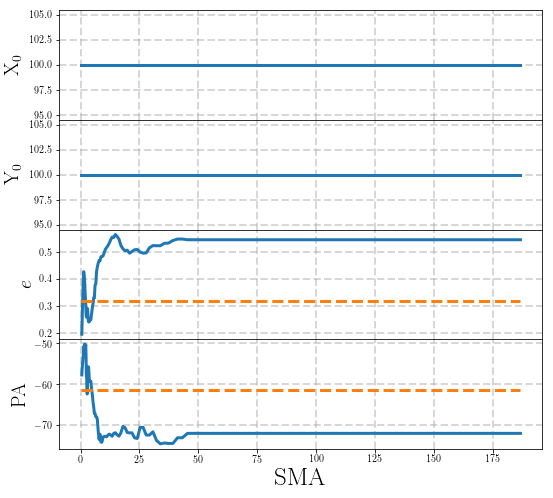

In [116]:
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(4, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax1.plot(iso_cen_2['sma'], iso_cen_2['x0'], linewidth=3.0)
ax1.set_ylabel(r'$\mathrm{X}_0$', fontsize=20)

ax2 = plt.subplot(4, 1, 2)
ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax2.plot(iso_cen_2['sma'], iso_cen_2['y0'], linewidth=3.0)
ax2.set_ylabel(r'$\mathrm{Y}_0$', fontsize=20)

ax3 = plt.subplot(4, 1, 3)
ax3.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax3.plot(iso_cen_2['sma'], iso_cen_2['ell'], linewidth=3.0)
ax3.plot(iso_cen_2['sma'], (1.0 - iso_cen_2['avg_q']), 
         linestyle='--', linewidth=3.0)
ax3.set_ylabel(r'$e$', fontsize=20)

ax4 = plt.subplot(4, 1, 4)
ax4.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax4.plot(iso_cen_2['sma'], iso_cen_2['pa'], linewidth=3.0)
ax4.set_ylabel(r'$\mathrm{PA}$', fontsize=20)
ax4.plot(iso_cen_2['sma'], iso_cen_2['avg_pa'],
         linestyle='--', linewidth=3.0)
ax4.set_xlabel(r'$\mathrm{SMA}$', fontsize=25)

Text(0.5,0,u'$\\mathrm{SMA/Pixel}^{1/4}$')

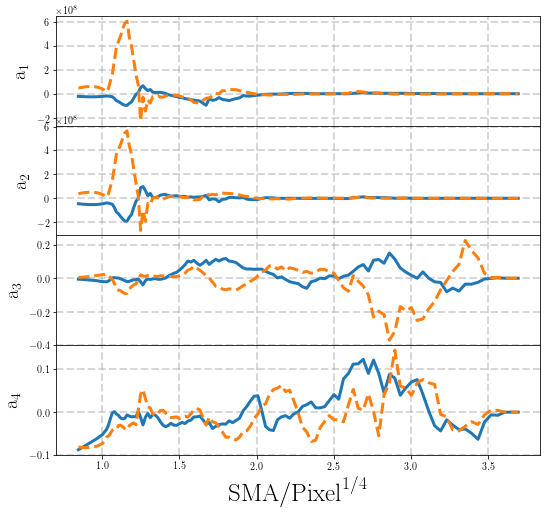

In [117]:
# When fitting the isophotes, we can add Fourier components to make it more flexible
# Here we can show the normalized amplitudes of the first four Fourier components. 

# Here, the bumpy features for A1 and A2 reflect the asymmetric feature.
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(4, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax1.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['a1'], linewidth=3.0)
ax1.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['b1'], linewidth=3.0, linestyle='--')
ax1.set_ylabel(r'$\mathrm{a}_1$', fontsize=20)

ax2 = plt.subplot(4, 1, 2)
ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax2.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['a2'], linewidth=3.0)
ax2.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['b2'], linewidth=3.0, linestyle='--')
ax2.set_ylabel(r'$\mathrm{a}_2$', fontsize=20)

ax3 = plt.subplot(4, 1, 3)
ax3.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax3.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['a3'], linewidth=3.0)
ax3.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['b3'], linewidth=3.0, linestyle='--')
ax3.set_ylabel(r'$\mathrm{a}_3$', fontsize=20)

ax4 = plt.subplot(4, 1, 4)
ax4.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax4.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['a4'], linewidth=3.0)
ax4.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['b4'], linewidth=3.0, linestyle='--')
ax4.set_ylabel(r'$\mathrm{a}_4$', fontsize=20)
ax4.set_xlabel(r'$\mathrm{SMA/Pixel}^{1/4}$', fontsize=25)

### Stage 3: Fix everything from the previous outputs

In [118]:
# Now, let's fix everything

iso_cen_3, iso_cen_3_bin = galSBP.galSBP('illustris_1_xy_cen.fits', 
                                         galX=100.0, 
                                         galY=100.0, 
                                         galQ=iso_cen_2['avg_q'][0], 
                                         galPA=iso_cen_2['avg_pa'][0], 
                                         maxSma=250, 
                                         iniSma=50.0, 
                                         stage=3, 
                                         intMode='median', 
                                         ellipStep=0.05,
                                         pix=pixel_scale, 
                                         zpPhoto=0.0,
                                         harmonics='1 2 3 4',
                                         isophote=x_isophote, 
                                         xttools=x_ttools,
                                         recenter=True,
                                         savePng=False, 
                                         verbose=True)

print('# Output file : %s' % iso_cen_3_bin)
print('# Total stellar mass from the profile: logM = %7.4f' % (iso_cen_3['mag_tot'][0] / -2.5))

----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : illustris_1_xy_cen.fits
###      Input Image   : temp_56SYH.fits
###      Output Binary : illustris_1_xy_cen_ellip_3.bin
----------------------------------------------------------------------------------------------------
---------------------------

/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:1614: RuntimeWarning: divide by zero encountered in log10
  expTime))


# Output file : illustris_1_xy_cen_ellip_3.bin
# Total stellar mass from the profile: logM = 12.3088


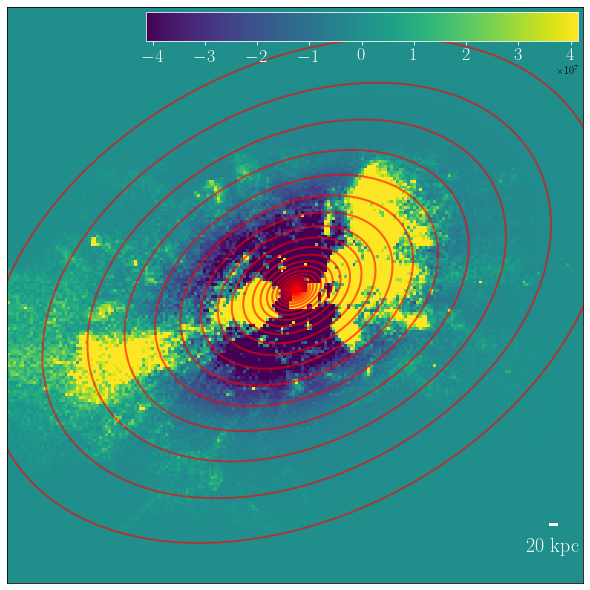

In [120]:
try: 
    os.remove(fits_prefix + '_cen_ellip_3.fits')
except Exception: 
    pass

iraf.bmodel(parent=fits_prefix + '_cen.fits', 
            table=iso_cen_3_bin,
            output=fits_prefix + '_cen_ellip_3.fits',
            minsma=0.0,
            highar='no')

img_cen_ellip_3 = fits.open(fits_prefix + '_cen_ellip_3.fits')[0].data

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.0, bottom=0.0,
                    top=1.0, right=1.0)
ax1 = fig.add_subplot(1, 1, 1)

ax1 = display_single(img_cen - img_cen_ellip_3, 
                     ax=ax1,
                     contrast=0.15,
                     scale_bar_length=20.0,
                     scale_bar_loc='right',
                     stretch='linear',
                     pixel_scale=1.0,
                     physical_scale=pixel_scale,
                     color_bar=True)

# Overplot a subsample of isophotes on the image
iso_cen_3_ellip = galSBP.convIso2Ell(iso_cen_3)
for ii, e in enumerate(iso_cen_3_ellip):
    if (ii % 4 == 0):
        ax1.add_artist(e)
        e.set_clip_box(ax1.bbox)
        e.set_alpha(0.6)
        e.set_edgecolor('r')
        e.set_facecolor('none')
        e.set_linewidth(2.0)

### Step 4: Make a 1D profile

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


Text(0.5,0,u'$\\mathrm{SMA/kpc}^{1/4}$')

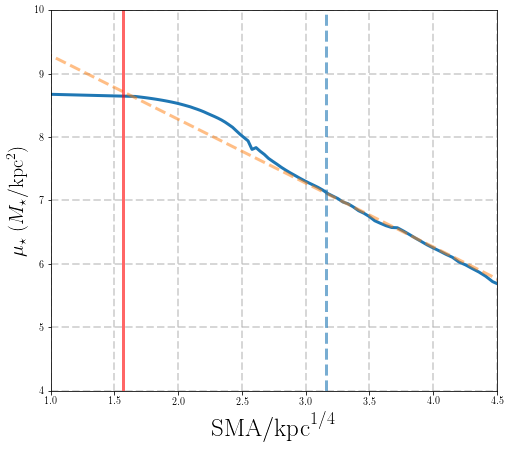

In [144]:
# Here is the 1-D mass density profile and the curve-of-growth of mass 

# I label the 6.0 kpc and 100 kpc radius
fig = plt.figure(figsize=(8, 7))

ax1 = plt.subplot(1, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)

# Overplot a de Vaucouleurs plot with Re=24 kpc
dev = models.Sersic1D(amplitude=np.median(iso_cen_3['intens'] / pixel_scale**2), 
                      r_eff=8, n=4.0)
ax1.plot((iso_cen_3['sma'] * pixel_scale) ** 0.25, 
         np.log10(iso_cen_3['intens'] / pixel_scale**2), linewidth=3.0)
ax1.plot((iso_cen_3['sma'] * pixel_scale) ** 0.25, 
         np.log10(dev(iso_cen_3['sma'])), linewidth=3.0, alpha=0.5,
         linestyle='--')
ax1.set_ylabel(r'$\mu_{\star}\ (M_{\star}/\mathrm{kpc}^2)$', fontsize=20)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.set_xlim(1.0, 4.5)
ax1.set_ylim(4.0, 10.0)

ax1.set_xlabel(r'$\mathrm{SMA/kpc}^{1/4}$', fontsize=25)


/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


(4.0, 10.0)

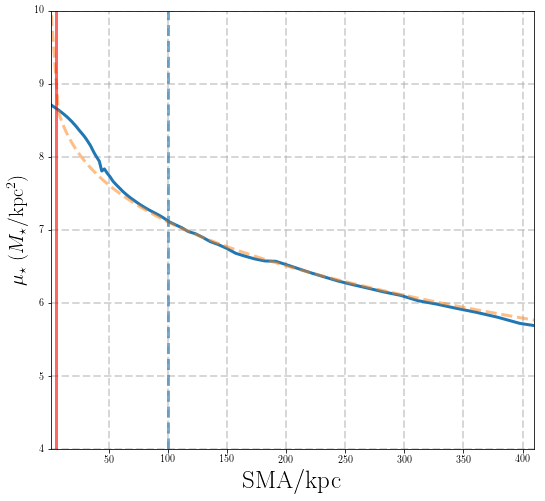

In [145]:
# And the difference becomes much more obvious when the X-axis is linear 

fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(1, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)

# Overplot a de Vaucouleurs plot with Re=24 kpc
dev = models.Sersic1D(amplitude=np.median(iso_cen_3['intens'] / pixel_scale**2), 
                      r_eff=8, n=4.0)
ax1.plot((iso_cen_3['sma'] * pixel_scale), 
         np.log10(iso_cen_3['intens'] / pixel_scale**2), linewidth=3.0)
ax1.plot((iso_cen_3['sma'] * pixel_scale), 
         np.log10(dev(iso_cen_3['sma'])), linewidth=3.0, alpha=0.5,
         linestyle='--')
ax1.set_ylabel(r'$\mu_{\star}\ (M_{\star}/\mathrm{kpc}^2)$', fontsize=20)
ax1.axvline(100.0, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

ax1.set_xlabel(r'$\mathrm{SMA/kpc}$', fontsize=25)
ax1.set_xlim(1.0, 4.5**4)
ax1.set_ylim(4.0, 10.0)


### Try fitting Sersic profiles with different number of components:

In [142]:
fitter = fitting.LevMarLSQFitter()
r_mask = (iso_cen_3['sma'] * pixel_scale > 6.0)
xx = iso_cen_3['sma'][r_mask]
yy = iso_cen_3['intens'][r_mask] / pixel_scale**2

# Let try to fit a Sersic function
ser1_init = models.Sersic1D(amplitude=np.nanmedian(iso_cen_3['intens'] / 9.0), 
                            r_eff=6.5, n=6.0)
ser1_fit = fitter(ser1_init, xx, yy)
print("# 1-Sersic model:")
print(ser1_fit.r_eff * 3.0, ser1_fit.n)

# Let try to fit 2-Sersic functions then
ser2_init = models.Sersic1D(amplitude=np.nanmedian(iso_cen_3['intens'] / 8.0), 
                            r_eff=2.5, n=3.0) + \
            models.Sersic1D(amplitude=np.nanmedian(iso_cen_3['intens'] / 12.0), 
                            r_eff=20.5, n=2.0)
ser2_fit = fitter(ser2_init, xx, yy)
print("\n# 2-Sersic model:")
print(ser2_fit.r_eff_0 * 3.0, ser2_fit.n_0)
print(ser2_fit.r_eff_1 * 3.0, ser2_fit.n_1)

# Let try to fit 3-Sersic functions then
ser3_init = models.Sersic1D(amplitude=np.nanmedian(iso_cen_3['intens'] / 6.0), 
                            r_eff=2.5, n=2.0) + \
            models.Sersic1D(amplitude=np.nanmedian(iso_cen_3['intens'] / 10.0), 
                            r_eff=12.5, n=1.5) + \
            models.Sersic1D(amplitude=np.nanmedian(iso_cen_3['intens'] / 15.0), 
                            r_eff=25.5, n=1.0)
ser3_fit = fitter(ser3_init, xx, yy)
print("\n# 3-Sersic model:")
print(ser3_fit.r_eff_0 * 3.0, ser3_fit.n_0)
print(ser3_fit.r_eff_1 * 3.0, ser3_fit.n_1)
print(ser3_fit.r_eff_2 * 3.0, ser3_fit.n_2)

# 1-Sersic model:
6.179118283 Parameter('n', value=0.685740549229)

# 2-Sersic model:
4.81434523526 Parameter('n_0', value=0.402060538811)
14.8512354146 Parameter('n_1', value=1.56717678251)

# 3-Sersic model:
4.97759975968 Parameter('n_0', value=0.158436066622)
4.92683728968 Parameter('n_1', value=0.607102393472)
19.0766516038 Parameter('n_2', value=1.23279944096)


/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


Text(0.5,0,u'$\\mathrm{SMA/kpc}^{1/4}$')

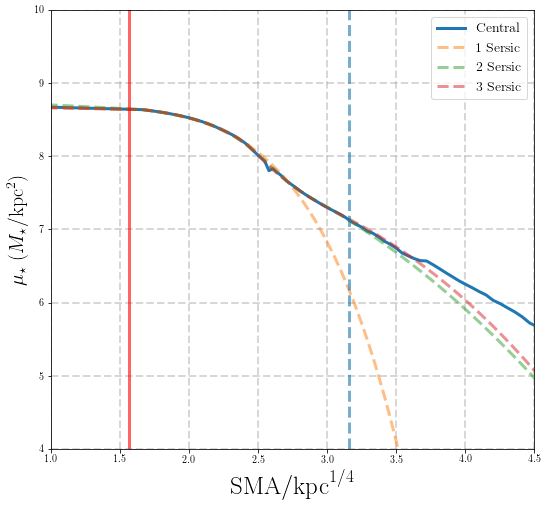

In [146]:
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(1, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax1.plot((iso_cen_3['sma'] * pixel_scale) ** 0.25, 
         np.log10(iso_cen_3['intens'] / pixel_scale**2), linewidth=3.0,
         label=r'$\mathrm{Central}$')
ax1.plot((iso_cen_3['sma'] * pixel_scale) ** 0.25, 
         np.log10(ser1_fit(iso_cen_3['sma'])), linewidth=3.0, alpha=0.5,
         linestyle='--', label=r'$\mathrm{1\ Sersic}$')
ax1.plot((iso_cen_3['sma'] * pixel_scale) ** 0.25, 
         np.log10(ser2_fit(iso_cen_3['sma'])), linewidth=3.0, alpha=0.5,
         linestyle='--', label=r'$\mathrm{2\ Sersic}$')
ax1.plot((iso_cen_3['sma'] * pixel_scale) ** 0.25, 
         np.log10(ser3_fit(iso_cen_3['sma'])), linewidth=3.0, alpha=0.5,
         linestyle='--', label=r'$\mathrm{3\ Sersic}$')
ax1.set_ylabel(r'$\mu_{\star}\ (M_{\star}/\mathrm{kpc}^2)$', fontsize=20)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.set_xlim(1.0, 4.5)
ax1.set_ylim(4.0, 10.0)
ax1.legend(fontsize=14)

ax1.set_xlabel(r'$\mathrm{SMA/kpc}^{1/4}$', fontsize=25)
